In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential 
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.layers import Dense, BatchNormalization, Embedding, LSTM
from keras.metrics import Precision
from keras import utils
from keras import callbacks
from sklearn.model_selection import train_test_split
from google.colab import drive
from absl import logging
logging.set_verbosity(logging.ERROR)  # ignore notification

In [2]:
! gdown --id 1JYBDszasL_IVYbKdDYnCPX46G58fIWZT 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JYBDszasL_IVYbKdDYnCPX46G58fIWZT
To: /content/data.csv
100% 36.1M/36.1M [00:00<00:00, 186MB/s]


# Data processing
Our goal at this stage is to transform the texts and labels in such a way that it is possible to submit data to the input of a recursive neural network: X, y

In [3]:
NUM_WORDS = 10000
MAX_TEXT_LEN = 200

In [4]:
# opening .csv files
df = pd.read_csv('/content/data.csv')

In [5]:
# deleting an extra column
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [6]:
def label_processing(labels: pd.Series) -> pd.Series:
    """The function of translation labels to a scale of 0 and 1"""
    processed_labels = labels.apply(func=(lambda value: 1 if value > 5 else 0))
    return processed_labels

def pickle_save(file_name: str, data: Tokenizer) -> None:
    """Data(tokens) saving function in pickle"""
    with open(file_name, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
texts = df['text']
labels = df['label'] 
labels.rename('y', inplace=True)
y = label_processing(labels)  # processed labels: y

In [8]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)  # training tokenizer 

In [9]:
# looking through the tokenizer dictionary
word_count = 50
keys = list(tokenizer.word_index.keys())[:word_count]
values = list(tokenizer.word_index.values())[:word_count]
list(zip(keys, values))

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('to', 4),
 ('of', 5),
 ('is', 6),
 ('it', 7),
 ('in', 8),
 ('i', 9),
 ('this', 10),
 ('that', 11),
 ('movie', 12),
 ('was', 13),
 ('but', 14),
 ('with', 15),
 ('for', 16),
 ('as', 17),
 ('film', 18),
 ('not', 19),
 ('you', 20),
 ('on', 21),
 ('are', 22),
 ('be', 23),
 ('have', 24),
 ('all', 25),
 ('like', 26),
 ("it's", 27),
 ('so', 28),
 ('one', 29),
 ('good', 30),
 ('his', 31),
 ('an', 32),
 ('from', 33),
 ('they', 34),
 ('just', 35),
 ('story', 36),
 ('at', 37),
 ('he', 38),
 ('by', 39),
 ('her', 40),
 ('or', 41),
 ('some', 42),
 ('there', 43),
 ('about', 44),
 ('has', 45),
 ('if', 46),
 ('what', 47),
 ('more', 48),
 ('very', 49),
 ('who', 50)]

In [10]:
pickle_save('tokenizer.pickle', tokenizer)  # saving  the tokens in a json file for further analysis

In [11]:
sequences = tokenizer.texts_to_sequences(texts)

In [12]:
# As a result, the text under the following index was converted to a vector
index = 0 
print(texts[index])
print(sequences[index])

A Canadian bankrobber in the eighties managed to rob dozens of banks. How did he do it? And did he get away with it?The good: this is simply a well made heist movie. Nothing out of the ordinary though, but what makes this movie still worth a watch are the good acting performances. Mel Gibson only has got a small supporting role by the way, so dont expect to see him much than 15 minutes, but in those 15 minutes he does act well being a rough and cunning old crime boss.But the 2 leading actors are a joy to watch as well, with good actor's chemistry. I was really suprised (and pleased) to see these 2 actors, whom I only knew vaguely, perform so naturally. I always like to see a bankrobber play it cool when he robs a bank and this character is not only cool, but also quite funny, in a understated way!This is simply a (slowburning) fun watch of a heist movie. Not laugh out loud funny. Nor is it spectacular. But nonetheless entertaining enough to award it with a decent 7 stars.
[3, 3630, 8, 

In [13]:
X = pad_sequences(sequences, maxlen=MAX_TEXT_LEN)  # Standardization of the number of elements in a vector

# Separation of data into training and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f'Training sample size: {len(X_train)}')
print(f'Test sample size: {len(X_test)}')

Training sample size: 37276
Test sample size: 9320


# Creating and training a recurrent model (LSTM)

In [15]:
model = Sequential()
model.add(Embedding(NUM_WORDS, 64, input_length=MAX_TEXT_LEN))
model.add(LSTM(3, return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(12))
model.add(Dense(1, activation='sigmoid'))

In [16]:
callbacks = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1),  
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=4, verbose=1, mode='auto')
]

In [17]:
model.compile(metrics=[Precision()], loss='binary_crossentropy', optimizer='rmsprop')

In [18]:
history = model.fit(X_train, y_train, batch_size=150, epochs=15, validation_split=0.2,  callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 13s 35ms/step - loss: 0.4581 - precision: 0.8001 - val_loss: 0.5256 - val_precision: 0.7898 - lr: 0.0010
Epoch 2/15
199/199 [==============================] - 6s 29ms/step - loss: 0.3286 - precision: 0.8832 - val_loss: 0.4438 - val_precision: 0.9144 - lr: 0.0010
Epoch 3/15
199/199 [==============================] - 6s 29ms/step - loss: 0.2798 - precision: 0.9010 - val_loss: 0.4004 - val_precision: 0.9208 - lr: 0.0010
Epoch 4/15
199/199 [==============================] - 6s 29ms/step - loss: 0.2497 - precision: 0.9148 - val_loss: 0.3500 - val_precision: 0.8463 - lr: 0.0010
Epoch 5/15
199/199 [==============================] - 7s 35ms/step - loss: 0.2234 - precision: 0.9260 - val_loss: 0.5026 - val_precision: 0.7971 - lr: 0.0010
Epoch 6/15
199/199 [==============================] - 6s 29ms/step - loss: 0.2048 - precision: 0.9331 - val_loss: 0.3563 - val_precision: 0.8628 - lr: 0.0010
Epoch 7/15
199/199 [==============================]

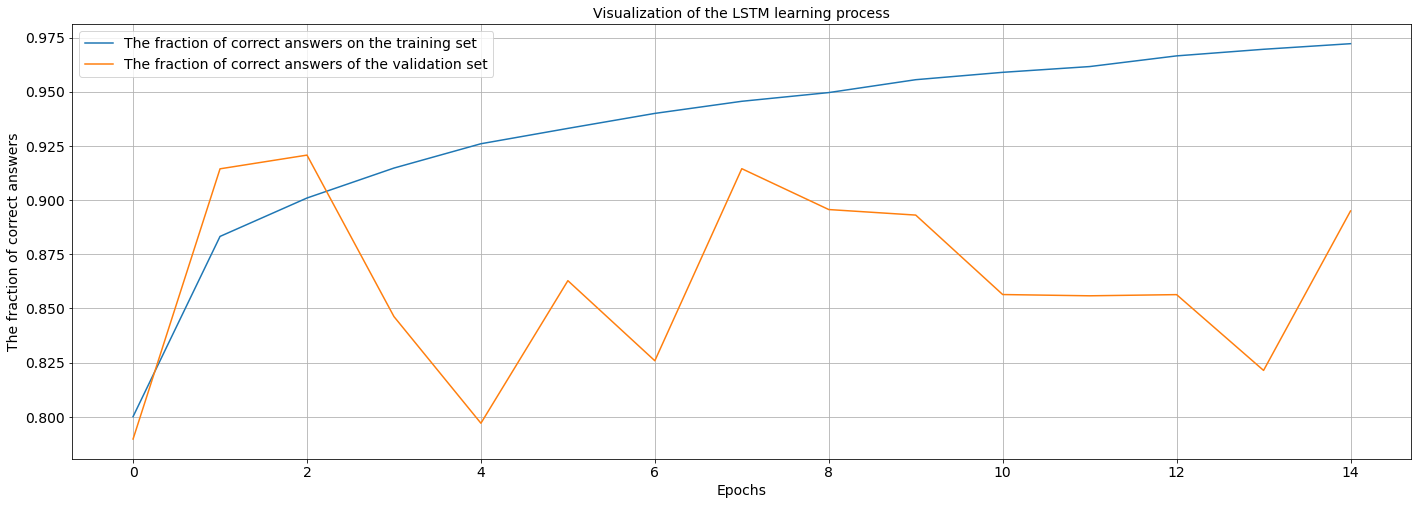

In [19]:
plt.figure(figsize=(24, 8))
plt.title('Visualization of the LSTM learning process', fontsize=14)
plt.plot(history.history['precision'], label='The fraction of correct answers on the training set') 
plt.plot(history.history['val_precision'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [20]:
print(f'Metric on test: {model.evaluate(X_test, y_test)}')
print(f'Metric on train: {model.evaluate(X_train, y_train)}')

292/292 [==============================] - 3s 12ms/step - loss: 0.5578 - precision: 0.8974
Metric on test: [0.5577755570411682, 0.897376537322998]
1165/1165 [==============================] - 13s 11ms/step - loss: 0.2040 - precision: 0.9676
Metric on train: [0.20396217703819275, 0.9676311016082764]


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 200, 3)            816       
                                                                 
 lstm_1 (LSTM)               (None, 200, 5)            180       
                                                                 
 batch_normalization (BatchN  (None, 200, 5)           20        
 ormalization)                                                   
                                                                 
 lstm_2 (LSTM)               (None, 12)                864       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                        

In [22]:
model.save('/content/drive/MyDrive')  # saving the lstm model for further analysis